In [1]:
import gym
import time
import numpy as np
import math

import torch 
import torch.nn as nn
import matplotlib.pyplot as plt

### Defining the environment and a network. Also, functions for evaluating the agent and rendering it

In [2]:
# env = gym.make('CartPole-v1')
# env._max_episode_steps = 200
env = gym.make('LunarLander-v2')


In [3]:
class Net(nn.Module):
    def __init__(self, obs_size, action_size):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, action_size),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)
    
net = Net(env.observation_space.shape[0],env.action_space.n)
print(net)

Net(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=4, bias=True)
    (5): Softmax(dim=1)
  )
)


In [4]:
def evaluate(env, net):
    rewards = 0
    steps = 0
    done = False
    state = env.reset()
    while not done:
        state = torch.FloatTensor([state])
        prob = net(state)
        acts = prob.max(dim=1)[1]
        new_state, reward, done, _ = env.step(acts.data.numpy()[0])
        rewards += reward
        state = new_state
        steps += 1
    
    return rewards, steps

In [5]:
def render_agent(env,net):
    done = False
    state = env.reset()
    while not done:
        env.render()
        state = torch.FloatTensor([state])
        prob = net(state)
        acts = prob.max(dim=1)[1]
        new_state, reward, done, _ = env.step(acts.data.numpy()[0])
        state = new_state
    env.close()

## ($\mu$,$\lambda$)-ES  

### Static 

In [6]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [7]:
def evolution_strategy_V2(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False):

    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)
    best_rewards = np.zeros(num_iters)
    
    population_size = children_size
    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    
    param_size = param_vec[0].size()[0]
    
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
            

        m = R.mean()
             
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        
        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")

    return param_vec, reward_per_iteration, best_rewards

iteration 0, rewards mean: -468.2584512806205, best reward: -138.675706709127
iteration 25, rewards mean: -212.15951480383734, best reward: 158.52103516070662
iteration 50, rewards mean: -117.14187034695584, best reward: 265.6911265285802
iteration 75, rewards mean: -239.96633201002783, best reward: -5.962061319450825
iteration 100, rewards mean: -146.6849585901348, best reward: 215.6796324860722
iteration 125, rewards mean: -70.23664636405769, best reward: 268.8194337721679
iteration 150, rewards mean: -57.89170506907077, best reward: 242.98581597901946
iteration 175, rewards mean: 40.37449996282155, best reward: 272.9352964283742
iteration 200, rewards mean: 75.51462857405976, best reward: 299.38618891291344
iteration 225, rewards mean: -84.45569314440458, best reward: 248.82867626089586
iteration 250, rewards mean: 19.018163804383413, best reward: 293.1060668856067
iteration 275, rewards mean: -31.441729291476562, best reward: 287.1507333411274
iteration 300, rewards mean: 43.375454

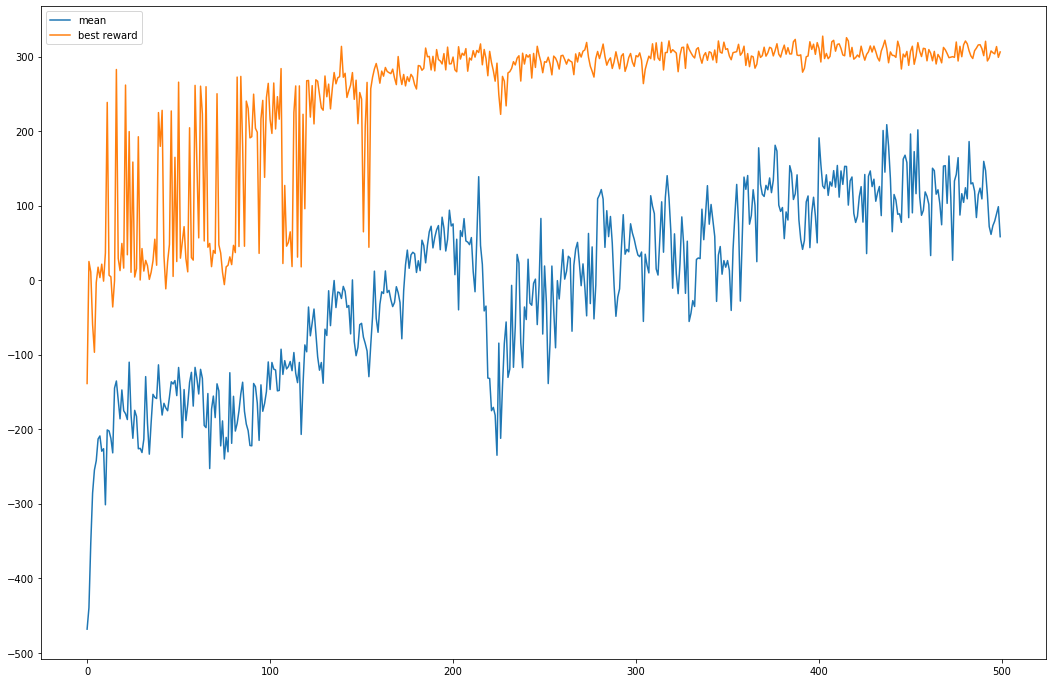

In [8]:
best_params, rewards, best_rewards = evolution_strategy_V2(
    f=evaluate,
    children_size= 10,
    sigma=1,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True,
    
)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()

plt.show()

### Adaptive:  1/5 rule

In [9]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [10]:
def evolution_strategy_V2_adaptive(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False,
    k = 10,
    C = 0.8):
    
    population_size = children_size
    
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)
    best_rewards = np.zeros(num_iters)
    
    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    
    param_size = param_vec[0].size()[0]
    
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
        
        m = R.mean()
             
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
            
        if t % k == 0:
            av_k = (np.array(reward_per_iteration[-k-1:-1])/m).astype('int32').sum()
            if  av_k > 1/5:
                sigma = sigma/C
            elif av_k < 1/5:
                sigma = sigma*C

    return param_vec, reward_per_iteration, best_rewards

iteration 0, rewards mean: -532.6413360619168, best reward: -122.79238869815701
iteration 25, rewards mean: -298.7085303037607, best reward: 249.5092431425591
iteration 50, rewards mean: 47.20407948184786, best reward: 267.4184808041099
iteration 75, rewards mean: 44.550492924458595, best reward: 263.84589243047554
iteration 100, rewards mean: -12.406853079354494, best reward: 277.3667517718947
iteration 125, rewards mean: 47.47344554529288, best reward: 273.51242121887447
iteration 150, rewards mean: 21.93560775513764, best reward: 281.43340697829115
iteration 175, rewards mean: 50.68888680298303, best reward: 266.56080022702156
iteration 200, rewards mean: -47.367446175043796, best reward: 259.06677912548184
iteration 225, rewards mean: -24.84718088445907, best reward: 264.8338999307651
iteration 250, rewards mean: 33.38311885442189, best reward: 268.52114932210566
iteration 275, rewards mean: 48.35805347878845, best reward: 276.67448383714105
iteration 300, rewards mean: 75.33341663

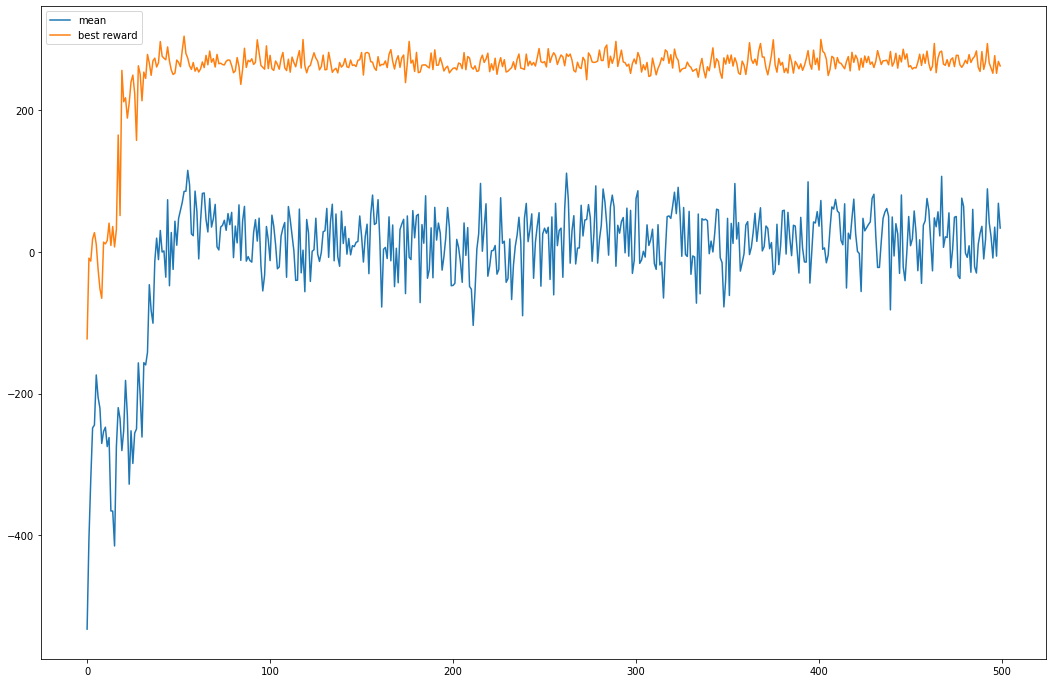

In [11]:
best_params, rewards, best_rewards = evolution_strategy_V2_adaptive(
    f=evaluate,
    children_size= 10,
    sigma=0.9,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True,
    k = 5
    
)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [12]:
# render_agent(env, net)

### self-adaptive single $\sigma$

In [13]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [14]:
def evolution_strategy_V2_self_adaptive_one_sigma(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    
    population_size = children_size
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    best_rewards = np.zeros(num_iters)

    param_size = param_vec[0].size()[0]
    lr = (1/math.sqrt(param_size))
    print("lr" , lr)
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                

        m = R.mean()
             
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
        sigma = sigma * math.exp(lr * np.random.randn())
        if sigma < 0.005:
            sigma = 0.005    


    return param_vec, reward_per_iteration, best_rewards

lr 0.010170251181863347
iteration 0, rewards mean: -653.612913718527, best reward: -31.53696541346129
iteration 25, rewards mean: -177.52246508489992, best reward: 29.840523066303092
iteration 50, rewards mean: -177.30342447106483, best reward: 151.96948118115296
iteration 75, rewards mean: -131.39606748385302, best reward: 28.881540726382156
iteration 100, rewards mean: -116.44442126216812, best reward: 259.5241691150956
iteration 125, rewards mean: -185.35898423968766, best reward: 162.187745978498
iteration 150, rewards mean: -100.57272053775868, best reward: 253.93570307759776
iteration 175, rewards mean: -155.5904161079596, best reward: 221.12813387889963
iteration 200, rewards mean: -192.61963513110905, best reward: 231.21056859913037
iteration 225, rewards mean: -103.91364434722695, best reward: 257.7622613065381
iteration 250, rewards mean: -118.21201968647455, best reward: 213.50700586484658
iteration 275, rewards mean: -143.77708511838782, best reward: 264.72756482224906
iter

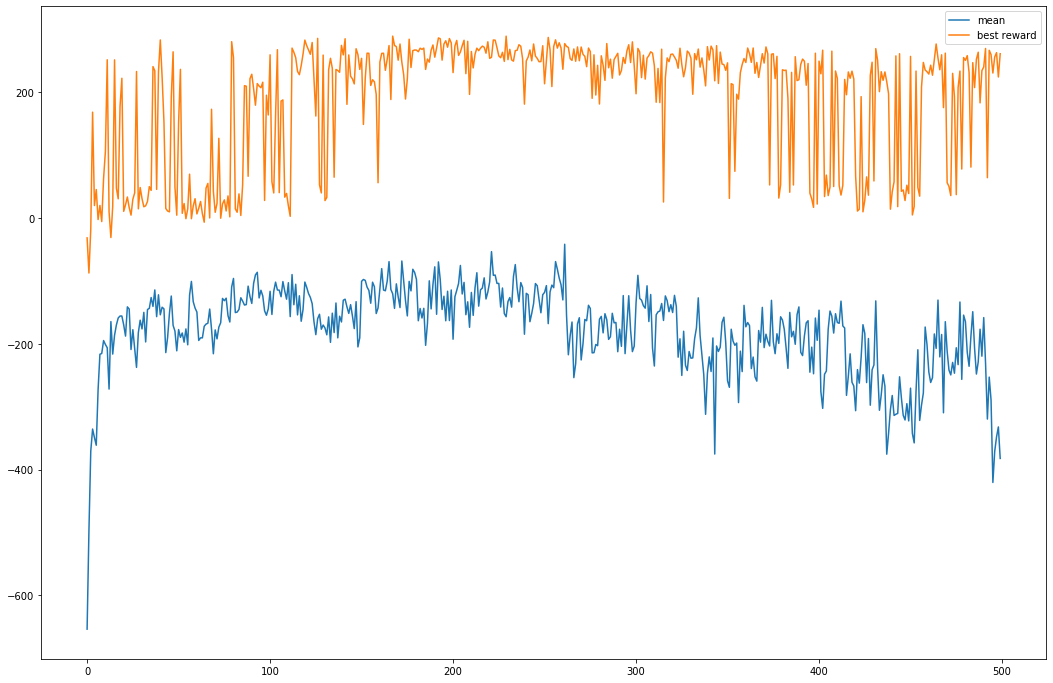

In [15]:
best_params, rewards, best_rewards = evolution_strategy_V2_self_adaptive_one_sigma(
    f=evaluate,
    children_size= 10,
    sigma=0.8,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True

)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [16]:
# render_agent(env, net)

### Self-adaptive multiple $\sigma$

In [17]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [18]:
def evolution_strategy_V2_self_adaptive_multiple_sigma(
    f,
    children_size,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    
    population_size = children_size
    # assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    best_rewards = np.zeros(num_iters)

    param_size = param_vec[0].size()[0]
    glr = 1/math.sqrt(param_size*2)
    cwlr = 1/math.sqrt(2*math.sqrt(param_size))
    sigmas = abs(np.random.randn(param_size))
    
    print("glr" , glr, "cwlr", cwlr)  
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
#         N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size ) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i].detach().numpy() + sigmas *N[i][j]
                params_try = torch.from_numpy(params_try.astype(np.float32))
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1


        m = R.mean()

        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
    
        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigmas * NN[i])


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()
        best_rewards[t] = max(R)

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
        for j in range(param_size):
            
            sigmas[j] = sigmas[j] * math.exp(glr * np.random.randn() *0.5 + cwlr * np.random.randn() * 0.5)
            
            if sigmas[j] < 0.005:
                sigmas[j] = 0.005 


    return param_vec, reward_per_iteration, best_rewards

glr 0.007191453577066072 cwlr 0.07131006654695866
iteration 0, rewards mean: -545.0198762163752, best reward: -186.61634656377237
iteration 25, rewards mean: -184.3186107160813, best reward: 26.73311559247348
iteration 50, rewards mean: -125.58389590272391, best reward: 45.39545881838518
iteration 75, rewards mean: -90.13181652399959, best reward: 38.50270478938447
iteration 100, rewards mean: -196.91616295273576, best reward: 26.858141946413113
iteration 125, rewards mean: -139.69601240699916, best reward: 255.19730404235764
iteration 150, rewards mean: -111.8456464722536, best reward: 51.08218592003422
iteration 175, rewards mean: -126.56177571373816, best reward: 54.32740448590084
iteration 200, rewards mean: -99.68287718666409, best reward: 228.61679893031277
iteration 225, rewards mean: -91.58943639530584, best reward: 192.66690227884254
iteration 250, rewards mean: -120.24956385635065, best reward: 249.23735596728977
iteration 275, rewards mean: -115.80552077286477, best reward: 

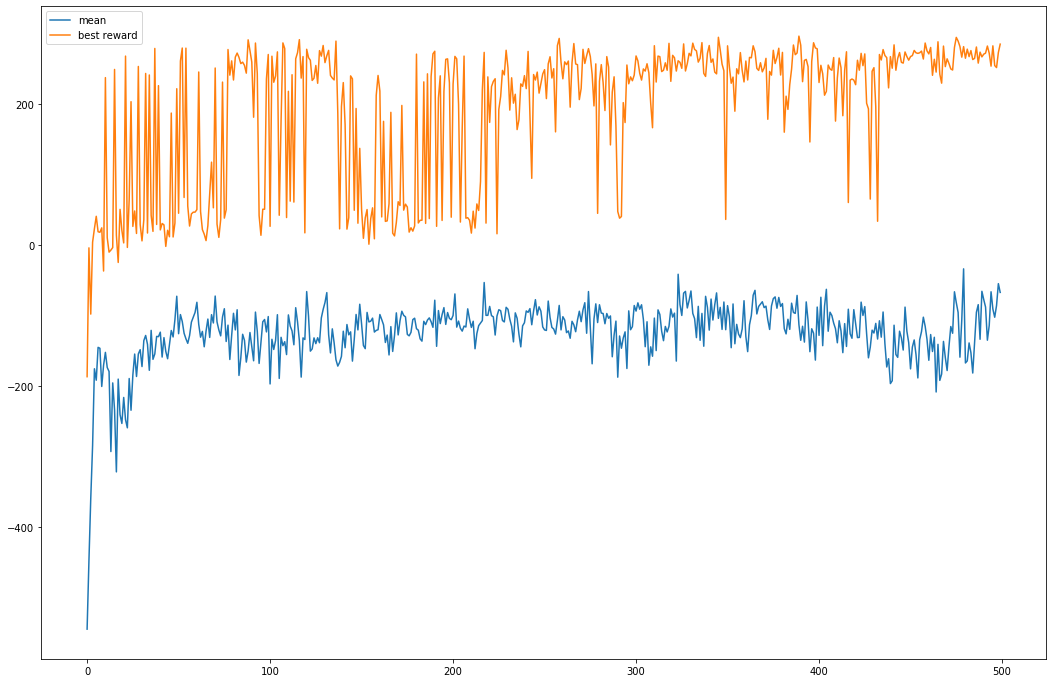

In [19]:
best_params, rewards, best_rewards = evolution_strategy_V2_self_adaptive_multiple_sigma(
    f=evaluate,
    children_size= 10,
    num_iters=500,
    net=net, 
    parent_size= 5,
    print_reward = True)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [20]:
# render_agent(env, net)

## ($\mu$+$\lambda$)-ES

## Static

In [24]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [25]:
def evolution_strategy_V2(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    population_size = children_size
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)
    best_rewards = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    
    param_size = param_vec[0].size()[0]
    
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size + 1)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size +1) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                
            #add parent to list 
            nn.utils.vector_to_parameters(param_vec[i], net.parameters())
            R[index_counter], _ = f(env,net)
            parent_indx[index_counter] = i
            NN.append(torch.from_numpy(np.array([0]).astype(np.float32)))
            index_counter += 1
            
        m = R.mean()

        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()
                
        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")

    return param_vec, reward_per_iteration, best_rewards

iteration 0, rewards mean: -466.89211554959564, best reward: -186.22400098872347
iteration 25, rewards mean: -239.2377318043165, best reward: 20.55982412229153
iteration 50, rewards mean: -146.7767929863393, best reward: 272.5815106371686
iteration 75, rewards mean: -181.08416611083607, best reward: 283.3170302350122
iteration 100, rewards mean: -168.98419463696115, best reward: 234.4569669454065
iteration 125, rewards mean: -222.26391812920983, best reward: 42.15299370578603
iteration 150, rewards mean: -261.98377472722046, best reward: 243.00877266480245
iteration 175, rewards mean: -256.0727918533288, best reward: 252.05712152971614
iteration 200, rewards mean: -199.7625371830289, best reward: 49.21694911450055
iteration 225, rewards mean: -183.87351448663864, best reward: 237.97522946810295
iteration 250, rewards mean: -150.05045056822985, best reward: 246.72772465731015
iteration 275, rewards mean: -124.60923907508094, best reward: 251.43500200630484
iteration 300, rewards mean: -

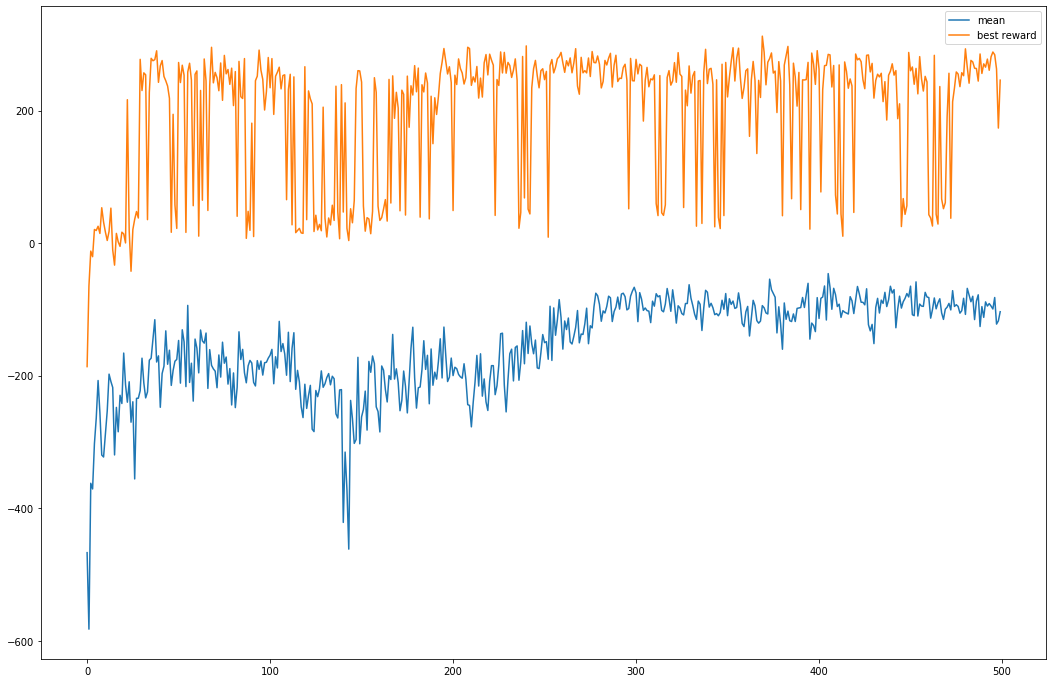

In [26]:
best_params, rewards, best_rewards = evolution_strategy_V2(
    f=evaluate,
    children_size= 10,
    sigma=1,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True,
    
)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [ ]:
# render_agent(env, net)

### Adaptive: 1/5 rule

In [27]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [28]:
def evolution_strategy_V2_adaptive(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False,
    k = 10,
    C = 0.8):
    
    population_size = children_size
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)
    best_rewards = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    
    param_size = param_vec[0].size()[0]
    
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size + 1)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size +1) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                
            #add parent to list 
            nn.utils.vector_to_parameters(param_vec[i], net.parameters())
            R[index_counter], _ = f(env,net)
            parent_indx[index_counter] = i
            NN.append(torch.from_numpy(np.array([0]).astype(np.float32)))
            index_counter += 1
        

        m = R.mean()
        
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
            
        if t % k == 0:
            av_k = (np.array(reward_per_iteration[-k-1:-1])/m).astype('int32').sum()
            if  av_k > 1:
                sigma = sigma/C
            elif av_k < 1:
                sigma = sigma*C

    return param_vec, reward_per_iteration, best_rewards

iteration 0, rewards mean: -396.6263637277383, best reward: -109.69454973777002
iteration 25, rewards mean: -178.91028385781988, best reward: 33.683691532058106
iteration 50, rewards mean: -108.77236276036611, best reward: 192.88050722556045
iteration 75, rewards mean: -113.53980926065492, best reward: 26.580651840499883
iteration 100, rewards mean: -160.1304197791306, best reward: 237.48731674234634
iteration 125, rewards mean: -187.25930308864997, best reward: 225.86684383584134
iteration 150, rewards mean: -176.655641582708, best reward: 195.71830176566377
iteration 175, rewards mean: -168.34586097367097, best reward: 205.85037323237566
iteration 200, rewards mean: -211.68088506814195, best reward: 246.12594615627748
iteration 225, rewards mean: -186.76871121607286, best reward: 256.5995683406842
iteration 250, rewards mean: -220.15019984585228, best reward: 237.7738541685114
iteration 275, rewards mean: -174.91827809399103, best reward: 264.56048476955533
iteration 300, rewards mea

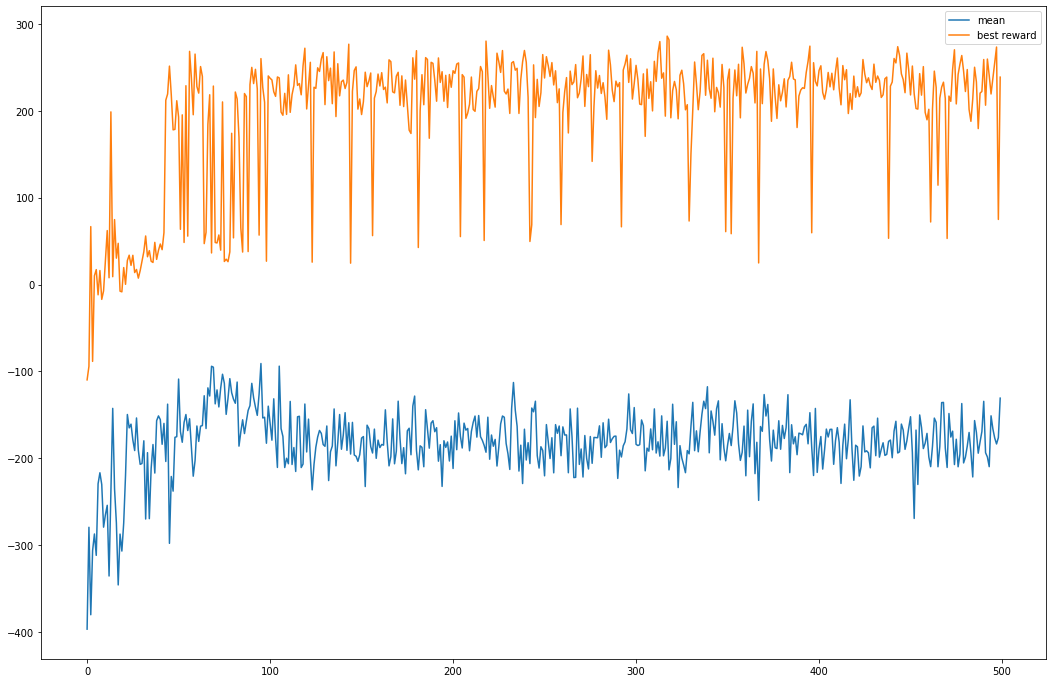

In [29]:
best_params, rewards, best_rewards = evolution_strategy_V2_adaptive(
    f=evaluate,
    children_size= 10,
    sigma=0.9,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True,
    k = 5
    
)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [30]:
# render_agent(env, net)

### self-adaptive single $\sigma$

In [31]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [32]:
def evolution_strategy_V2_self_adaptive_one_sigma(
    f,
    children_size,
    sigma,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    
    population_size = children_size
    #assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    best_rewards = np.zeros(num_iters)

    param_size = param_vec[0].size()[0]
    #parent_indx = []
    lr = (1/math.sqrt(param_size))
    print("lr" , lr)
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
        N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size + 1)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size +1) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i] + sigma*N[i][j]
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                
            #add parent to list 
            nn.utils.vector_to_parameters(param_vec[i], net.parameters())
            R[index_counter], _ = f(env,net)
            parent_indx[index_counter] = i
            NN.append(torch.from_numpy(np.array([0]).astype(np.float32)))
            index_counter += 1

        m = R.mean()

        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
        best_rewards[t] = max(R)

        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigma * NN[i].detach().numpy())


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
        sigma = sigma * math.exp(lr * np.random.randn())
        if sigma < 0.005:
            sigma = 0.005    


    return param_vec, reward_per_iteration, best_rewards

lr 0.010170251181863347
iteration 0, rewards mean: -479.571840333579, best reward: -46.28556499856114
iteration 25, rewards mean: -156.1358325564247, best reward: 15.362782628515632
iteration 50, rewards mean: -1.7192313462987396, best reward: 255.929254009829
iteration 75, rewards mean: -15.261753395477927, best reward: 272.2232905748048
iteration 100, rewards mean: 30.563199887910233, best reward: 311.4647718647003
iteration 125, rewards mean: 66.73772428947018, best reward: 297.03810955401633
iteration 150, rewards mean: 11.765091240014751, best reward: 318.5353031257656
iteration 175, rewards mean: 7.74024262872495, best reward: 298.3873125315422
iteration 200, rewards mean: -30.244914240674603, best reward: 302.5891123576594
iteration 225, rewards mean: -73.71242042607194, best reward: 302.6178210690462
iteration 250, rewards mean: -41.26441950382052, best reward: 301.37277600988676
iteration 275, rewards mean: -38.82895145724242, best reward: 277.939731687616
iteration 300, rewar

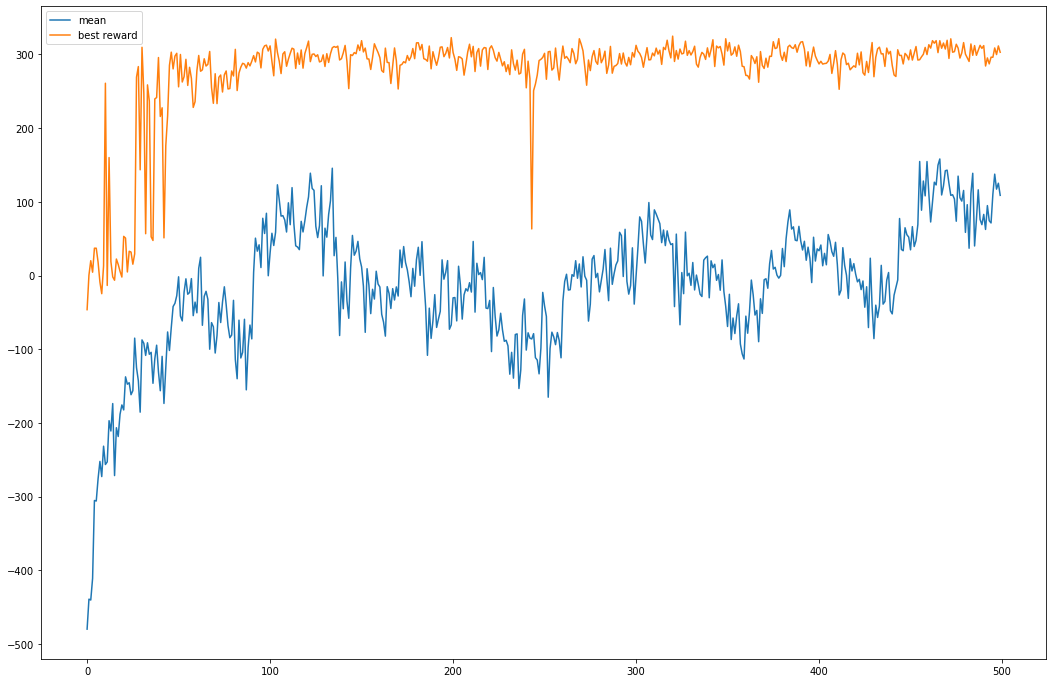

In [33]:
best_params, rewards, best_rewards = evolution_strategy_V2_self_adaptive_one_sigma(
    f=evaluate,
    children_size= 10,
    sigma=0.8,
    num_iters=500,
    net=net,
    parent_size= 5,
    print_reward = True

)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [34]:
# render_agent(env, net)

### Self-adaptive multiple $\sigma$

In [35]:
net = Net(env.observation_space.shape[0],env.action_space.n)

In [36]:
def evolution_strategy_V2_self_adaptive_multiple_sigma(
    f,
    children_size,
    num_iters,
    net,
    parent_size,
    print_reward = False):
    
    
    population_size = children_size
    # assume initial params is a 1-D array
    reward_per_iteration = np.zeros(num_iters)

    #params = initial_params
    param_vec = []
    param_vec.append(nn.utils.parameters_to_vector(net.parameters()))
    best_rewards = np.zeros(num_iters)

    param_size = param_vec[0].size()[0]
    glr = 1/math.sqrt(param_size*2)
    cwlr = 1/math.sqrt(2*math.sqrt(param_size))
    sigmas = abs(np.random.randn(param_size))
    
    print("glr" , glr, "cwlr", cwlr)  
    for t in range(num_iters):
        N = np.random.randn(len(param_vec), population_size, param_size)
#         N = torch.from_numpy(N.astype(np.float32))
        R = np.zeros((len(param_vec) ) * (population_size + 1)) # stores the reward
        
        parent_indx = np.zeros((len(param_vec)) * (population_size +1) )
        NN = []
        index_counter = 0
        
        #loop through each parent
        for i in range(len(param_vec)):
            
            # loop through each "offspring"
            for j in range(population_size):
                params_try = param_vec[i].detach().numpy() + sigmas *N[i][j]
                params_try = torch.from_numpy(params_try.astype(np.float32))
                nn.utils.vector_to_parameters(params_try, net.parameters())
                R[index_counter], _ = f(env,net)
                parent_indx[index_counter] = i
                NN.append( N[i][j] )
                index_counter += 1
                
            #add parent to list 
            nn.utils.vector_to_parameters(param_vec[i], net.parameters())
            R[index_counter], _ = f(env,net)
            parent_indx[index_counter] = i
            NN.append(np.array([0]))
            index_counter += 1

        m = R.mean()
             
        reward_per_iteration[t] = m
        top_index = np.argpartition(R, -parent_size)[-parent_size:]
        param_vec2 = []
    
        for i in top_index:
            param_vec2.append(param_vec[int(parent_indx[i])].detach().numpy() + sigmas * NN[i])


        param_vec.clear()
        param_vec = param_vec2.copy()
        param_vec2.clear()
        best_rewards[t] = max(R)

        for i in range(len(param_vec)):
            param_vec[i] = torch.Tensor(param_vec[i])
        if print_reward and t%25 == 0:
            print(f"iteration {t}, rewards mean: {m}, best reward: {max(R)}")
            
        for j in range(param_size):
            
            sigmas[j] = sigmas[j] * math.exp(glr * np.random.randn() *0.5 + cwlr * np.random.randn() * 0.5)
            
            if sigmas[j] < 0.005:
                sigmas[j] = 0.005 


    return param_vec, reward_per_iteration, best_rewards

glr 0.007191453577066072 cwlr 0.07131006654695866
iteration 0, rewards mean: -448.6081461384125, best reward: -47.567820996825375
iteration 25, rewards mean: -204.68802559536695, best reward: 264.99243581403823
iteration 50, rewards mean: -170.03551676015053, best reward: 41.50057371238137
iteration 75, rewards mean: -177.8835078218742, best reward: 252.4535584903661
iteration 100, rewards mean: -88.72229552135664, best reward: 264.0089485140828
iteration 125, rewards mean: -96.60765475807942, best reward: 263.34269416681934
iteration 150, rewards mean: -115.12149365707145, best reward: 51.897773683537366
iteration 175, rewards mean: -156.4804538157589, best reward: 269.8820463301922
iteration 200, rewards mean: -129.32941128185425, best reward: 227.55904320301065
iteration 225, rewards mean: -209.21868270947954, best reward: 247.1449255932153
iteration 250, rewards mean: -153.82201349723155, best reward: 278.16494500652664
iteration 275, rewards mean: -131.71080004279315, best reward:

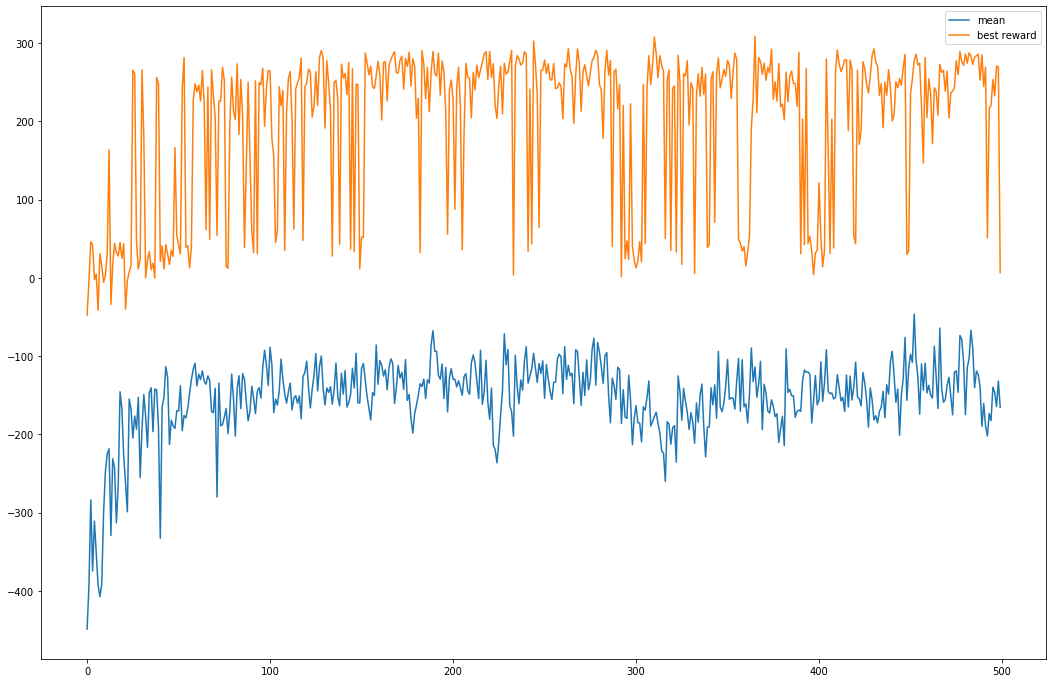

In [37]:
best_params, rewards, best_rewards = evolution_strategy_V2_self_adaptive_multiple_sigma(
    f=evaluate,
    children_size= 10,
    num_iters=500,
    net=net, 
    parent_size= 5,
    print_reward = True)

# plot the rewards per iteration
plt.figure(figsize=(18, 12))
plt.plot(rewards, label = 'mean')
plt.plot(best_rewards, label = 'best reward')
plt.legend()
plt.show()

In [ ]:
# nn.utils.vector_to_parameters(best_params, net.parameters())

In [55]:
render_agent(env, net)